In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [311]:
time_slice_size = 10000
#5000 second slices

In [344]:
cat_df = pd.read_csv("catalogs/apollo12_catalog_GradeA_final.csv")
data_path = "data/"

activity_detected = 0

i = 0

for filename in cat_df["filename"]:
    try:
        df = pd.read_csv(data_path + filename + ".csv")
        activity_detected = cat_df["time_rel(sec)"][i]
        if(i>=19):
            break
    except(FileNotFoundError):
        continue
    i+=1


In [345]:
filename

'xa.s12.00.mhz.1971-03-25HR00_evid00028'

In [346]:
cleaned_df = df.drop(['time_abs(%Y-%m-%dT%H:%M:%S.%f)'], axis=1)

In [347]:
scalar = StandardScaler()
normalized_df = scalar.fit_transform(cleaned_df.values)
normalized_df

array([[-1.73204778,  0.00287469],
       [-1.73204173,  0.00287437],
       [-1.73203568,  0.00287432],
       ...,
       [ 1.73203568,  0.00287591],
       [ 1.73204173,  0.00287565],
       [ 1.73204778,  0.00287533]])

In [348]:
Iso_Forest = IsolationForest(contamination=0.001,random_state=123) 
spikes = Iso_Forest.fit_predict(pd.DataFrame(normalized_df))
spikes

array([1, 1, 1, ..., 1, 1, 1])

In [349]:
len(spikes)

572427

In [350]:
count_spikes = 0
for val in spikes:
    if val == -1:
        count_spikes += 1
count_spikes

571

In [351]:
outliers = [100] * len(spikes)
for i, val in enumerate(spikes):
    if val == -1:
        outliers[i] = normalized_df[i]
        print(normalized_df[i])
outliers = pd.Series(outliers)

# Ensure all values in outliers are numeric
outliers = pd.to_numeric(outliers, errors='coerce')

# Check for NaNs and handle them
if outliers.isna().any():
    print("Warning: NaN values found in outliers. Replacing NaNs with 0.")
    outliers = outliers.fillna(0)


[-0.25486936 -5.1594091 ]
[-0.25486331 -5.2195459 ]
[-0.25485726 -5.27968269]
[-0.25485121 -5.33981948]
[-0.25484515 -5.39995627]
[ 0.48371077 -6.23467324]
[ 0.48639768 -7.4559226 ]
[ 0.48713598 -7.72548298]
[ 0.4872207 -6.4885722]
[ 0.48722675 -6.40095175]
[ 0.48762616 -5.99407287]
[ 0.48901803 -6.28474435]
[ 0.48933271 -5.99521609]
[ 0.48933876 -6.40727578]
[0.48936297 7.71388301]
[ 0.48938718 -7.82722007]
[ 0.48939323 -7.4846784 ]
[0.48941138 7.52552046]
[0.48941743 8.41849508]
[ 0.48944164 -6.69403902]
[ 0.48972607 -7.03417022]
[ 0.48996813 -5.95551783]
[ 0.49086982 -6.13366968]
[ 0.49116635 -5.92354056]
[0.49143262 8.01264217]
[ 0.49145683 -6.35298113]
[ 0.49146288 -6.59610359]
[ 0.49171099 -5.96749775]
[ 0.49188649 -6.64985777]
[ 0.49189254 -8.05447236]
[ 0.49245534 -8.50542542]
[ 0.49246139 -7.61298244]
[0.49247955 7.54019598]
[ 0.49250375 -7.75592485]
[0.49252796 8.86407214]
[ 0.49258848 -9.26725106]
[ 0.49259453 -9.40066107]
[0.49261268 8.86168617]
[0.49261873 9.76475644]
[0.4

/var/folders/9f/w_h_8p515yg_kwww45j_kn0w0000gn/T/ipykernel_10029/3816275786.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


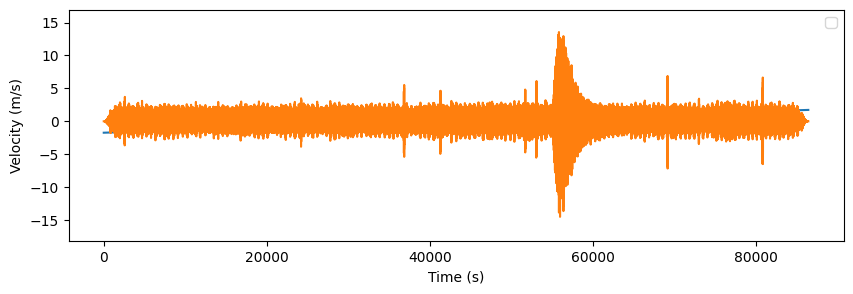

In [352]:

# len(outliers)
len(df['time_rel(sec)'])


# Plot the trace!
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(df['time_rel(sec)'],normalized_df)
# Make the plot pretty
ax.set_ylim((np.min(normalized_df)*1.25, np.max(normalized_df)*1.25))
ax.set_ylabel('Velocity (m/s)') 
ax.set_xlabel('Time (s)') 

# ax.scatter(df['time_rel(sec)'], outliers, c="red", label="Anomaly")
plt.legend()
plt.show()

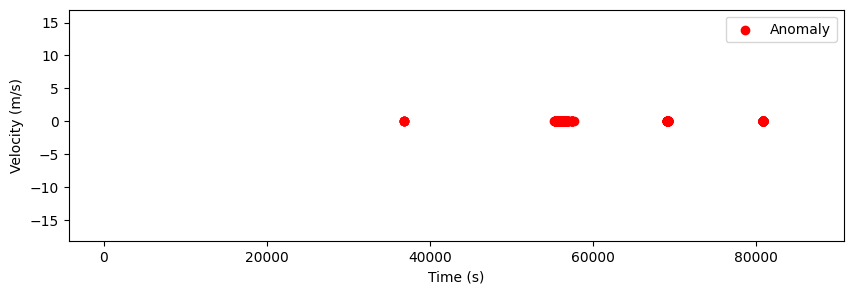

In [353]:
# Plot the trace!
fig,ax = plt.subplots(1,1,figsize=(10,3))
# Make the plot pretty
ax.set_ylim((np.min(normalized_df)*1.25, np.max(normalized_df)*1.25))
ax.set_ylabel('Velocity (m/s)') 
ax.set_xlabel('Time (s)') 

ax.scatter(df['time_rel(sec)'], outliers, c="red", label="Anomaly")
plt.legend()
plt.show()

In [354]:
data = pd.DataFrame(columns=['avg_chunk_accel', 'label'])
random_forest = RandomForestClassifier()

index = 0
counter = 0
row = 0

DATA = 0
LABEL = 1

for spike in spikes:
    if spike == -1 and counter >= index: 
        start_time = df['time_rel(sec)'][index]
        index += time_slice_size
        sliced_frame = (df[df['time_rel(sec)'].between(start_time, start_time+time_slice_size)])
        vel = sliced_frame['velocity(m/s)']
        
        avg_accel = (vel.iloc[-1] - vel.iloc[0])/len(vel)
        temp = pd.DataFrame(columns=['avg_chunk_accel', 'label'])
        if(start_time+time_slice_size >= activity_detected >= start_time - time_slice_size/2):
            data.loc[row] = [avg_accel,1]
        else:
            data.loc[row] = [avg_accel,0]
        
        row += 1
    if index > len(spikes):
        break
    if index == counter:
        index += 1
        
    counter += 1

In [355]:
random_forest.fit(pd.DataFrame(data['avg_chunk_accel']), pd.DataFrame(data['label']))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier()

In [356]:
data

,avg_chunk_accel,label
0,2.318204e-14,0.0
1,2.450532e-14,1.0
2,3.438834e-14,1.0
3,2.308905e-14,0.0
4,4.923401e-14,0.0
